# Oil and Gas production Forcasting - Prophet model

This notebook applies the Facebook Prophet model to forecast gas production. It includes tuning of model hyperparameters and saving the standardized results for future comparison across models.

Notes:

* Both Prophet and ARIMA models only use the time variable (period, denoted as ds) and the target variable (daily production MBBL/D, denoted as y) because these methods:

    - Are designed for univariate time series forecasting.

    - Internally model seasonality, trends, and changepoints.

    - Do not incorporate exogenous variables in their standard configurations.

About Prophet:

Prophet is an additive time series model that assumes the observed data is composed of several components summed together:

* Trend: Captures the overall direction or progression of the time series over time, such as an increasing or decreasing pattern.

* Seasonality: Represents recurring patterns that repeat at regular intervals, like weekly or yearly cycles.

* Holidays/Events: Models special occurrences causing irregular spikes or drops in the data, corresponding to known events or holidays.



### 1-Imports and Dataset

In [23]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import optuna

In [24]:
#load features dataset
df = pd.read_csv("../data/processed/oil_production_features.csv")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values(by='period')

In [25]:
df_prophet = df[['period', 'MBBL/D']].rename(columns={'period': 'ds', 'MBBL/D': 'y'})

### 2-Train-test split

In [ ]:
train_size = int(len(df_prophet)*0.8)
train = df_prophet[:train_size]
test = df_prophet[train_size:]

### 3-Bayesian hyperparameter tuning

In [35]:
def objective(trial):
    """Objective function for Optuna hyperparameter tuning."""
    model = Prophet(
        changepoint_prior_scale=trial.suggest_float("changepoint_prior_scale", 0.001, 0.5, log=True),
        seasonality_prior_scale=trial.suggest_float("seasonality_prior_scale", 0.01, 10.0, log=True),
        holidays_prior_scale=trial.suggest_float("holidays_prior_scale", 0.01, 10.0, log=True),
        yearly_seasonality=True,
    )
    
    model.fit(train)
    future = model.make_future_dataframe(periods=len(test), freq='MS')
    forecast = model.predict(future)
    y_pred = forecast.iloc[-len(test):]['yhat'].values
    y_true = test['y'].values
    return mean_absolute_error(y_true, y_pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-09-17 16:09:29,822] A new study created in memory with name: no-name-7ba196ce-8955-4126-a63e-9bc5bed1c1a4
16:09:29 - cmdstanpy - INFO - Chain [1] start processing
16:09:29 - cmdstanpy - INFO - Chain [1] done processing
16:09:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:09:29 - cmdstanpy - INFO - Chain [1] start processing
16:09:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-17 16:09:30,761] Trial 0 finished with value: 896.7689764363938 and parameters: {'changepoint_prior_scale': 0.001134853906304319, 'seasonality_prior_scale': 0.4012046037634144, 'holidays_prior_scale': 0.18485636385676227}. Best is trial 0 with value: 896.7689764363938.
16:09:30 - cmdstanpy - INFO - Chain [1] start processing
16:09:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-17 16:09:31,057] Trial 1 finished with value: 1144.5079420472657 and parameters: {'changepoint_prio

In [36]:
best_params = study.best_params
print("Best hyperparameters: ", best_params)

Best hyperparameters:  {'changepoint_prior_scale': 0.0089317826434469, 'seasonality_prior_scale': 0.013731629871358803, 'holidays_prior_scale': 0.0342439807941808}


In [37]:
#Saving the best parameters to JSON file
with open('../models/prophet_best_params.json', 'w') as f:
    json.dump(best_params, f)

### 4-Train Final Model

In [38]:
model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    yearly_seasonality=True,
)
model.fit(df_prophet)

16:10:06 - cmdstanpy - INFO - Chain [1] start processing
16:10:06 - cmdstanpy - INFO - Chain [1] done processing


### 5-Forecasting

In [39]:
future = model.make_future_dataframe(periods=len(test), freq='MS')
forecast = model.predict(future)

#Extracting predictions
y_pred = forecast.iloc[-len(test):]['yhat'].values
y_true = test['y'].values

### 6-Standardized evaluation metrics

In [40]:
metrics = {
    "MAE": mean_absolute_error(y_true, y_pred),
    "MSE": mean_squared_error(y_true, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
    "R2": r2_score(y_true, y_pred),
    "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
}
print(metrics)

{'MAE': 665.5036699419211, 'MSE': 543887.9865014878, 'RMSE': np.float64(737.4876178631664), 'R2': -11.589643736953771, 'MAPE': np.float64(37.93939325551011)}


In [41]:
# Save the model and the results.
results = {"model": "PROPHET", "metrics": metrics}
with open('../results/prophet_results.json', 'w') as f:
    json.dump(results, f)


# Save predictions and metrics.
pd.DataFrame({"ds": test['ds'], "y_true": y_true, "y_pred": y_pred}).to_csv(
    "../results/prophet_predictions.csv", index=False
)

### 7-Plot predictions

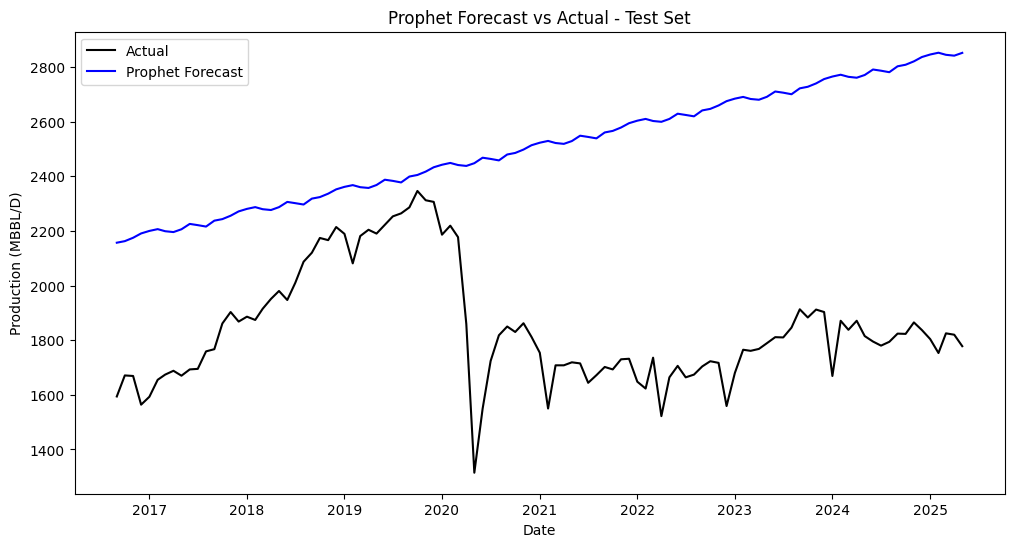

In [42]:
plt.figure(figsize=(12,6))
plt.plot(test['ds'], y_true, label='Actual', color='black')
plt.plot(test['ds'], y_pred, label='Prophet Forecast', color='blue')
plt.title("Prophet Forecast vs Actual - Test Set")
plt.xlabel("Date")
plt.ylabel("Production (MBBL/D)")
plt.legend()
plt.show()

Bayesian hyperparameter optimization using Optuna was employed to tune the Prophet model parameters. Model evaluation was conducted on a holdout test set comprising 20% of the data. The resulting performance metrics and predictions were saved in standardized files to facilitate fair and reproducible comparisons with ARIMA and LSTM models. This comprehensive setup ensures consistent benchmarking across different modeling approaches in the notebook 6-model-comparison.ipynb